In [1]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

In [2]:
json_filename = 'configs/config_sononet_8_6classes.json'
json_opts = json_file_to_pyobj(json_filename)
train_opts = json_opts.training

In [3]:
us_data = h5py.File('data/image_inp_224x288.hdf5')

In [4]:
cardiac_classes = [1, 2, 22, 29]
other_classes = [4, 15, 31]
all_classes = cardiac_classes + other_classes
class_dict = {1:0, 29:0, 2:1, 22:2, 4:3, 15:4, 31:5}
class_names = dict(zip([class_dict[c] for c in all_classes], us_data['label_names'].value[[c for c in all_classes]]))

In [5]:
class_names

{0: b'RVOT', 1: b'4CH', 2: b'LVOT', 3: b'ABDOMINAL', 4: b'FEMUR', 5: b'SPINE'}

In [6]:
train_id = np.array([i in all_classes for i in us_data['plane_labels_train'].value])
test_id = np.array([i in all_classes for i in us_data['plane_labels_test'].value])

In [7]:
images_train = torch.tensor(us_data['images_train'][train_id,:,:,:])
labels_train = torch.tensor([class_dict[lab] for lab in us_data['plane_labels_train'][train_id]])

images_test = torch.tensor(us_data['images_test'][test_id,:,:,:])
labels_test = torch.tensor([class_dict[lab] for lab in us_data['plane_labels_test'][test_id]])

In [8]:
arch_type = train_opts.arch_type
ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




In [9]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [10]:
class AlteredUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]
        self.embedding = data[2]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]
        emb = self.embedding[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target), emb

    def __len__(self):
        return len(self.images)

In [11]:
train_dataset = SimpleUSDataset(
    (images_train, labels_train),
    transform=ds_transform['train'])
train_dataset_for_acc = SimpleUSDataset(
    (images_train, labels_train),
    transform=ds_transform['valid'])
test_dataset = SimpleUSDataset(
    (images_test, labels_test),
        transform=ds_transform['valid'])

In [12]:
batch_size = train_opts.batchSize
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, 300)

In [13]:
train_loader = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True)
#    sampler=train_sampler)

train_loader_for_acc = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

test_loader  = DataLoader(test_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

In [14]:
def print_accuracy(model, fold):
    model.net.eval()
    if fold == 'train':
        loader = train_loader_for_acc
    elif fold == 'test':
        loader = test_loader
    labels = []
    preds = []
    for (img, lab) in loader:
        labels.append(lab.cpu())
        model.set_input(img)
        model.forward(split='test')
        preds.append(model.logits.cpu().argmax(dim=1))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    acc = (labels==preds).sum().float() / len(labels)
    print('Accuracy {fold}: {acc}'.format(
        fold=fold, acc=acc
    ))
    return acc

In [15]:
model = get_model(json_opts.model)


Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(

In [16]:
model.set_labels([0,1,2,3,4,5])
model.set_scheduler(train_opts)
model.load_network(model.net, '6classes', 50)
model.update_state(0)

opt.lr_policy = [step_warmstart]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.010000000000000002
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-06
)
Loading the model 6classes - epoch 50


In [18]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.backends.cudnn.deterministic=True

model = get_model(json_opts.model)
model.update_state(0)
model.optimizer.param_groups[0]['lr'] = 0.01

for epoch in tqdm(range(1, 51)):
    for (images, labels) in train_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters()

    if epoch % 2 == 0:
        model.save_network(model.net, '6classes', epoch, model.gpu_ids)
        #print_accuracy(model, 'train')
        #print_accuracy(model, 'test')

    if epoch == 25:
        model.optimizer.param_groups[0]['lr'] = 0.001

0%|          | 0/50 [00:00<?, ?it/s]
Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), pad

In [23]:
def get_logits(model, fold, softmax=True):
    model.net.eval()
    with torch.no_grad():
        if fold == 'train':
            loader = train_loader_for_acc
        elif fold == 'test':
            loader = test_loader
        labels = []
        logits = []
        for (img, lab) in loader:
            labels.append(lab.cpu())
            model.set_input(img)
            model.forward(split='test')
            if softmax:
                logits.append(model.logits.cpu())
            else:
                logits.append(model.prediction.cpu())
        labels = torch.cat(labels)
        logits = torch.cat(logits)
        return logits, labels

In [24]:
logits_train_before, labels_train = get_logits(model, 'train', softmax=False)

In [17]:
from ptsne.ptsne import ParametricTSNE

In [25]:
ptsne = ParametricTSNE(6, 2, 50, use_cuda=True, hidden_layer_dims=[200,50], alpha='learn')

In [20]:
ptsne.load_state_dict(torch.load('checkpoints/ifind1_sononet_8_6classes/ptsne.pt'))

AttributeError: 'function' object has no attribute 'copy'

In [26]:
ptsne.fit(logits_train_before, pretrain=True, verbose=True)

Calculating PCA
2020-03-12 16:47:20.808061: Beginning pretraining for 5 epochs
2020-03-12 16:47:21.178090: Loss after epoch 0: 26.29618400335312
2020-03-12 16:47:21.396056: Loss after epoch 1: 4.054888308048248
2020-03-12 16:47:21.489059: Loss after epoch 2: 1.440170057117939
2020-03-12 16:47:21.586092: Loss after epoch 3: 0.6359109319746494
2020-03-12 16:47:21.680093: Loss after epoch 4: 0.280973419547081
2020-03-12 16:47:21.681058: Finished pretraining
Indexing
Calculating probabilities: 4777/47772020-03-12 16:47:44.870280: Beginning training for 10 epochs
2020-03-12 16:47:45.233279: Loss after epoch 1: 18.858836735602193
2020-03-12 16:47:45.554280: Loss after epoch 2: 15.53159032466505
2020-03-12 16:47:45.882288: Loss after epoch 3: 14.860591553388554
2020-03-12 16:47:46.209798: Loss after epoch 4: 14.321512859023112
2020-03-12 16:47:46.527798: Loss after epoch 5: 14.20651486386252
2020-03-12 16:47:46.862795: Loss after epoch 6: 13.932189997088457
2020-03-12 16:47:47.178795: Loss af

In [27]:
projected = ptsne(logits_train_before.cuda()).cpu().detach()

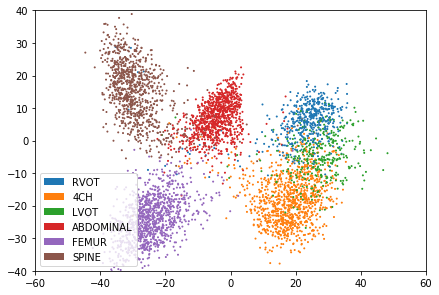

In [28]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in labels_train]
ax.scatter(projected[:,0], projected[:,1], c=colors, s=1)
ax.set_aspect(1)
ax.set_xlim([-60,60])
ax.set_ylim([-40,40])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in class_names.values()],loc=3)

In [29]:
shifted_train = torch.cat((
    (3./4. * projected[(labels_train == 0)] + 1./4. * projected[(labels_train == 0)].mean(axis=0)) + torch.tensor([0.,3.]),
    (3./4. * projected[(labels_train == 1)] + 1./4. * projected[(labels_train == 1)].mean(axis=0)) + torch.tensor([2.,-5.]),
    (2./3. * projected[(labels_train == 2)] + 1./3. * projected[(labels_train == 2)].mean(axis=0)) + torch.tensor([5.,0.]),
    projected[(labels_train == 3)],
    projected[(labels_train == 4)],
    projected[(labels_train == 5)]
))
labels_shifted =  torch.cat([labels_train[(labels_train == i)] for i in range(6)])

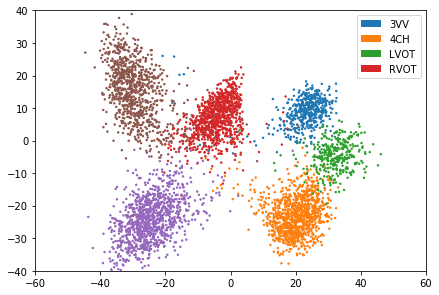

In [30]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in labels_shifted]
ax.scatter(shifted_train[:,0], shifted_train[:,1], c=colors, s=2)
ax.set_aspect(1)
ax.set_xlim([-60,60])
ax.set_ylim([-40,40])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [31]:
torch.save(ptsne.state_dict(), 'checkpoints/ifind1_sononet_8_6classes/ptsne.pt')

In [32]:
#train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, 2000)
shifted_dataset = AlteredUSDataset((images_train, labels_train, shifted_train), transform=ds_transform['valid'])
shifted_loader = DataLoader(shifted_dataset, batch_size=batch_size, shuffle=True)

In [36]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.backends.cudnn.deterministic=True

model = get_model(json_opts.model)
model.load_network(model.net, '6classes', 50)
model.update_state(0)
model.optimizer.param_groups[0]['lr'] = 0.001

for epoch in tqdm(range(1, 20)):
    for batch, (images, labels, emb) in enumerate(shifted_loader):
        # Make a training update
        model.set_input(images, labels)
        c_loss, e_loss = model.optimize_parameters_altered(ptsne, emb.cuda(), 0.0, return_losses=True)

        with open('6_classes_class_log.txt', 'a') as text_file:
            print('Ep {ep}, batch {batch}: Cl. loss = {cl}, Emb. loss = {el}'.format(
            ep=epoch, batch=batch, cl=c_loss, el=e_loss), file=text_file)

    model.save_network(model.net, '6classes_class', epoch, model.gpu_ids)
        #print_accuracy(model, 'train')
        #print_accuracy(model, 'test')

#    if epoch == :
#        model.optimizer.param_groups[0]['lr'] = 0.00 5
    #     model.update_learning_rate()

# for epoch in tqdm(range(1, 21)):
#     for idx, (images, labels, emb) in enumerate(shifted_loader):
#         # Make a training update
#         model.net.train()
#         model.set_input(images, labels)

#         model.optimize_parameters_altered(ptsne, emb.cuda(), 0.1)

#     model.save_network(model.net, 'emb_010_from_50', epoch, model.gpu_ids)
    
    # if epoch == 10:
    #      model.optimizer.param_groups[0]['lr'] = 0.0001

    # if epoch == 25:
    #     model.update_learning_rate()

        #model.update_learning_rate(metric=valid_err, epoch=epoch)


  0%|          | 0/19 [00:00<?, ?it/s]
Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), 

In [190]:
logits_emb = {'train':[], 'test':[]}
for epoch in range(1, 20):
    model.load_network(model.net, 'emb_010_from_50', epoch)
    logits_emb['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_emb['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_emb['train'] = torch.stack(logits_emb['train'])
logits_emb['test'] = torch.stack(logits_emb['test'])
torch.save(logits_emb, 'checkpoints/ifind1_sononet_8_andi/logits_emb_010_from_50.pt')

Loading the model emb_010_from_50 - epoch 1
Loading the model emb_010_from_50 - epoch 2
Loading the model emb_010_from_50 - epoch 3
Loading the model emb_010_from_50 - epoch 4
Loading the model emb_010_from_50 - epoch 5
Loading the model emb_010_from_50 - epoch 6
Loading the model emb_010_from_50 - epoch 7
Loading the model emb_010_from_50 - epoch 8
Loading the model emb_010_from_50 - epoch 9
Loading the model emb_010_from_50 - epoch 10
Loading the model emb_010_from_50 - epoch 11
Loading the model emb_010_from_50 - epoch 12
Loading the model emb_010_from_50 - epoch 13
Loading the model emb_010_from_50 - epoch 14
Loading the model emb_010_from_50 - epoch 15
Loading the model emb_010_from_50 - epoch 16
Loading the model emb_010_from_50 - epoch 17
Loading the model emb_010_from_50 - epoch 18
Loading the model emb_010_from_50 - epoch 19


In [191]:
logits_class = {'train':[], 'test':[]}
for epoch in range(1, 20):
    model.load_network(model.net, 'class_only_from_50', epoch)
    logits_class['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_class['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_class['train'] = torch.stack(logits_class['train'])
logits_class['test'] = torch.stack(logits_class['test'])
torch.save(logits_emb, 'checkpoints/ifind1_sononet_8_andi/logits_class_only_from_50.pt')

Loading the model class_only_from_50 - epoch 1
Loading the model class_only_from_50 - epoch 2
Loading the model class_only_from_50 - epoch 3
Loading the model class_only_from_50 - epoch 4
Loading the model class_only_from_50 - epoch 5
Loading the model class_only_from_50 - epoch 6
Loading the model class_only_from_50 - epoch 7
Loading the model class_only_from_50 - epoch 8
Loading the model class_only_from_50 - epoch 9
Loading the model class_only_from_50 - epoch 10
Loading the model class_only_from_50 - epoch 11
Loading the model class_only_from_50 - epoch 12
Loading the model class_only_from_50 - epoch 13
Loading the model class_only_from_50 - epoch 14
Loading the model class_only_from_50 - epoch 15
Loading the model class_only_from_50 - epoch 16
Loading the model class_only_from_50 - epoch 17
Loading the model class_only_from_50 - epoch 18
Loading the model class_only_from_50 - epoch 19


In [41]:
logits_emb = dict()
logits_emb['train'] = get_logits(model, 'train', softmax=False)[0]
logits_emb['test'] = get_logits(model, 'test', softmax=False)[0]

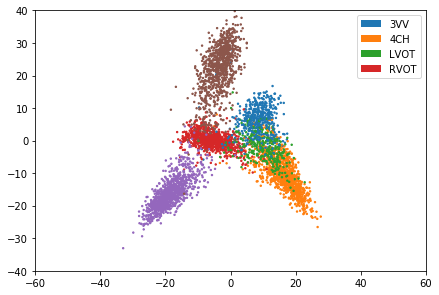

In [42]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in labels_train]
ax.scatter(projected_emb[:,0], projected_emb[:,1], c=colors, s=2)
ax.set_aspect(1)
ax.set_xlim([-60,60])
ax.set_ylim([-40,40])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

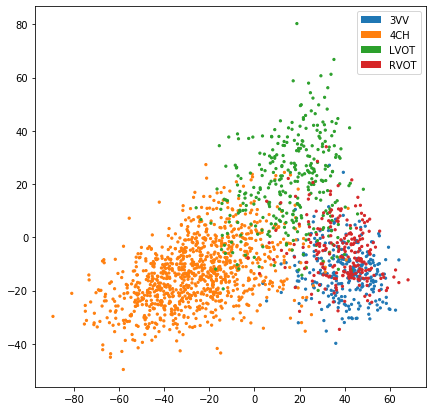

In [193]:
projected_altered = ptsne(logits_emb['train'][-1].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(projected_altered[:,0], projected_altered[:,1], c=colors, s=5)
#ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [46]:
def confmat(data):
    num_classes = len(np.unique(data[1]))
    cf = torch.zeros(num_classes,num_classes, dtype=torch.int)
    for logits, label, in zip(*data):
        cf[label, logits.softmax(dim=0).argmax()] += 1
    return cf

In [44]:
def accuracy(data):
    cf = confmat(data)
    diag = cf.diagonal().sum()
    total = cf.sum()
    return diag.float() / total

In [46]:
def precision(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[:,c].sum().float()

In [47]:
def recall(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[c,:].sum().float()

In [56]:
def f_score(data, c):
    cf = confmat(data)
    prec = cf[c,c].float() / cf[:,c].sum().float()
    rec = cf[c,c].float() / cf[c,:].sum().float()
    return torch.sqrt(prec * rec)

In [47]:
accuracy((get_logits(model, 'train', softmax=False)))

tensor(0.9140)

In [54]:
confmat((logits_train_before, labels_train))

tensor([[ 419,   39,   32,    8,    3,    8],
        [  28,  959,   20,   11,    2,    5],
        [  57,  100,  171,    0,    0,    4],
        [   8,    4,    0,  905,    3,    7],
        [   0,    5,    0,   18, 1034,    9],
        [   0,    2,    0,   20,    3,  893]], dtype=torch.int32)

In [67]:
f_score((logits_train_before, labels_train),2)

tensor(0.6285)

In [56]:
f_score((logits_emb['train'], labels_train),3)

tensor(0.3764)

In [194]:
accs_train_class = [accuracy((log, card_labels_train)) for log in logits_class['train']]
accs_test_class = [accuracy((log, card_labels_test)) for log in logits_class['test']]

In [195]:
accs_train_emb = [accuracy((log, card_labels_train)) for log in logits_emb['train']]
accs_test_emb = [accuracy((log, card_labels_test)) for log in logits_emb['test']]

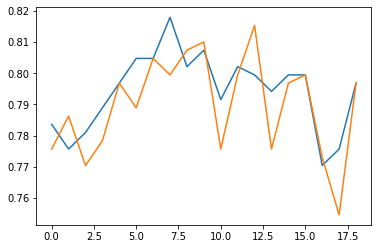

In [196]:
plt.plot(accs_test_class)
plt.plot(accs_test_emb)

In [197]:
f_score_0_test_class = [f_score((log, card_labels_test), 0) for log in logits_class['train']]
f_score_1_test_class = [f_score((log, card_labels_test), 1) for log in logits_class['train']]
f_score_2_test_class = [f_score((log, card_labels_test), 2) for log in logits_class['train']]
f_score_3_test_class = [f_score((log, card_labels_test), 3) for log in logits_class['train']]

In [198]:
f_score_0_test_emb = [f_score((log, card_labels_test), 0) for log in logits_emb['train']]
f_score_1_test_emb = [f_score((log, card_labels_test), 1) for log in logits_emb['train']]
f_score_2_test_emb = [f_score((log, card_labels_test), 2) for log in logits_emb['train']]
f_score_3_test_emb = [f_score((log, card_labels_test), 3) for log in logits_emb['train']]

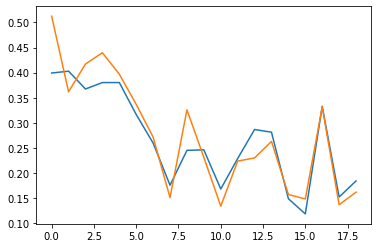

In [199]:
plt.plot(f_score_1_test_class)
plt.plot(f_score_1_test_emb)

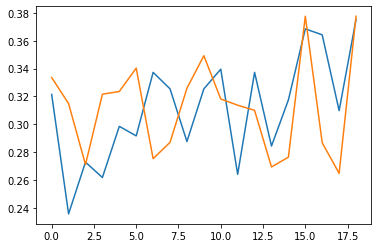

In [200]:
plt.plot(f_score_0_test_class)
plt.plot(f_score_0_test_emb)

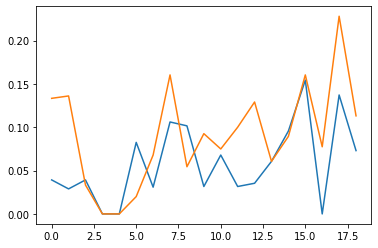

In [201]:
plt.plot(f_score_2_test_class)
plt.plot(f_score_2_test_emb)

In [204]:
plt.plot(f_score_3_train_class)
plt.plot(f_score_3_train_emb)

NameError: name 'f_score_3_train_class' is not defined

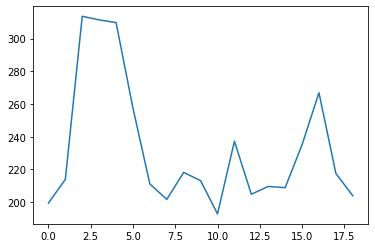

In [203]:
plt.plot([torch.nn.MSELoss()(ptsne(i.cuda()).cpu().detach(), shifted_train) for i in logits_emb['train']])

In [147]:
torch.nn.MSELoss()(ptsne(logits_emb['train'][-1].cuda()).cpu().detach(), projected_altered)

tensor(0.)

In [148]:
projected_altered

tensor([[ 42.7284, -15.9286],
        [ 47.1825, -14.0878],
        [ 41.6880, -17.5944],
        ...,
        [ 39.7183,  -3.3601],
        [ 49.3516,  10.9254],
        [ 53.0084,  -5.0605]])

In [150]:
ptsne(logits_emb['train'][-1].cuda()).cpu().detach()

tensor([[ 42.7284, -15.9286],
        [ 47.1825, -14.0878],
        [ 41.6880, -17.5944],
        ...,
        [ 39.7183,  -3.3601],
        [ 49.3516,  10.9254],
        [ 53.0084,  -5.0605]])